## Project 2: Road Segmentation of Satellite images with CNN

#### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, sys, glob, re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from PIL import Image
import torch
import torch.nn as nn
from torch.nn.functional import *
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import *

import torchvision
import torchvision.transforms as T
from torchvision import models

C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\valer\miniconda3\envs\ada\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# local imports
from utils.helpers import *
from cnn import *
from utils.augmented_dataset import *
from utils.submissions import *

In [3]:
if torch.cuda.is_available():
    print("Name of the Graphics card", torch.cuda.get_device_name())
    print("Number of GPU available", torch.cuda.device_count())
    device = "cuda"
else:
    print("No GPU available on this machine")
    device = "cpu"

Name of the Graphics card NVIDIA GeForce RTX 2060
Number of GPU available 1


#### Loading images and groundtruths

In [4]:
# Loaded a set of images
root_dir = "data/training/"
image_test = "data/test_set_images"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)
#n = min(30, len(files))
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


Image size = 400,400


Text(0.5, 1.0, 'real and groundtruth images')

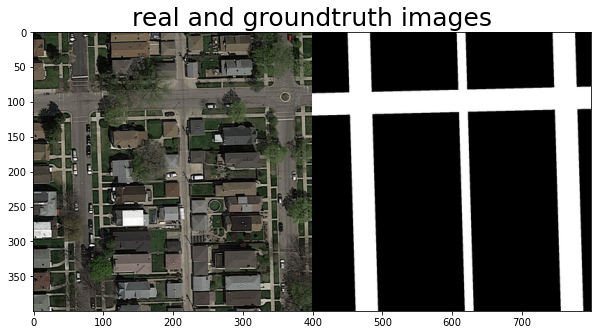

In [5]:
%matplotlib inline
i=5
print('Image size = ' + str(imgs[i].shape[0]) + ',' + str(imgs[i].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[i], gt_imgs[i])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')
plt.title("real and groundtruth images", fontdict={'fontsize':25})

#### Extracting image patches and their label

In [6]:
# Extract patches and labels
patch_size = 16
window_size = 64
padding = (window_size - patch_size) // 2
img_patches, Y = extract_patches_labels(imgs, gt_imgs, patch_size, padding, n)

# Mean and std of our dataset of image patches
mean_img = np.mean(img_patches, axis=(0, 1, 2))
std_img = np.std(img_patches, axis=(0, 1, 2))



#### Training and Validation datasets

In [7]:
# Trainset and Validation sets
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
dataset_train = DataLoader(TrainsetCNN(img_train, Y_train, mean_img, std_img), batch_size=batch_size, sampler=sampler)
dataset_valid = DataLoader(TrainsetCNN(img_valid, Y_valid, mean_img, std_img), batch_size=batch_size, shuffle=True)

print("Number of patches in the training dataset: {}".format(len(img_train)))
print("Number of patches in the validation dataset: {}".format(len(img_valid)))

Dealing with imbalanced datasets
Background weight: 0.674
Road weight: 1.939
Number of patches in the training dataset: 50000
Number of patches in the validation dataset: 12500


## Training the CNN

In [12]:
# hyperparameters
num_epochs = 50
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

#### Performance of the Model without Data Augmentation

Starting training


100%|████████████████████████████████████████| 250/250 [00:40<00:00,  6.20it/s]


Epoch 1
val accuracy: 0.79349, f1-score: 0.68594



100%|████████████████████████████████████████| 250/250 [00:34<00:00,  7.16it/s]


Epoch 2
val accuracy: 0.85119, f1-score: 0.76030



100%|████████████████████████████████████████| 250/250 [00:35<00:00,  7.13it/s]


Epoch 3
val accuracy: 0.88214, f1-score: 0.80253



100%|████████████████████████████████████████| 250/250 [00:27<00:00,  8.95it/s]


Epoch 4
val accuracy: 0.90698, f1-score: 0.83357



100%|████████████████████████████████████████| 250/250 [00:37<00:00,  6.66it/s]


Epoch 5
val accuracy: 0.88683, f1-score: 0.78301



100%|████████████████████████████████████████| 250/250 [00:38<00:00,  6.56it/s]


Epoch 6
val accuracy: 0.90889, f1-score: 0.83000



100%|████████████████████████████████████████| 250/250 [00:36<00:00,  6.91it/s]


Epoch 7
val accuracy: 0.89714, f1-score: 0.81273



100%|████████████████████████████████████████| 250/250 [00:41<00:00,  6.00it/s]


Epoch 8
val accuracy: 0.89310, f1-score: 0.82074



100%|████████████████████████████████████████| 250/250 [00:47<00:00,  5.21it/s]


Epoch 9
val accuracy: 0.90246, f1-score: 0.83296



100%|████████████████████████████████████████| 250/250 [00:41<00:00,  5.99it/s]


Epoch 10
val accuracy: 0.90706, f1-score: 0.81743



100%|████████████████████████████████████████| 250/250 [00:51<00:00,  4.88it/s]


Epoch 11
val accuracy: 0.90151, f1-score: 0.82965



100%|████████████████████████████████████████| 250/250 [00:42<00:00,  5.87it/s]


Epoch 12
val accuracy: 0.90595, f1-score: 0.84020



100%|████████████████████████████████████████| 250/250 [00:25<00:00,  9.74it/s]


Epoch 13
val accuracy: 0.92802, f1-score: 0.85994



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.50it/s]


Epoch 14
val accuracy: 0.91484, f1-score: 0.83760



100%|████████████████████████████████████████| 250/250 [00:26<00:00,  9.54it/s]


Epoch 15
val accuracy: 0.92238, f1-score: 0.86430



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.70it/s]


Epoch 16
val accuracy: 0.93127, f1-score: 0.86722



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.03it/s]


Epoch 17
val accuracy: 0.93325, f1-score: 0.87852



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.35it/s]


Epoch 18
val accuracy: 0.93421, f1-score: 0.87942



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.77it/s]


Epoch 19
val accuracy: 0.91833, f1-score: 0.85676



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.82it/s]


Epoch 20
val accuracy: 0.92603, f1-score: 0.86772



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.46it/s]


Epoch 21
val accuracy: 0.93952, f1-score: 0.88404



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.65it/s]


Epoch 22
val accuracy: 0.92936, f1-score: 0.86638



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.29it/s]


Epoch 23
val accuracy: 0.93651, f1-score: 0.88470



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.12it/s]


Epoch 24
val accuracy: 0.91325, f1-score: 0.81614



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.43it/s]


Epoch 25
val accuracy: 0.93056, f1-score: 0.87600



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.24it/s]


Epoch 26
val accuracy: 0.93968, f1-score: 0.88796



100%|████████████████████████████████████████| 250/250 [00:18<00:00, 13.55it/s]


Epoch 27
val accuracy: 0.93984, f1-score: 0.88795



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.74it/s]


Epoch 28
val accuracy: 0.94524, f1-score: 0.89339



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.39it/s]


Epoch 29
val accuracy: 0.92738, f1-score: 0.86415



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.70it/s]


Epoch 30
val accuracy: 0.93270, f1-score: 0.87899



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.57it/s]


Epoch 31
val accuracy: 0.93746, f1-score: 0.88532



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.47it/s]


Epoch 32
val accuracy: 0.93127, f1-score: 0.86710



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.30it/s]


Epoch 33
val accuracy: 0.91722, f1-score: 0.83090



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.03it/s]


Epoch 34
val accuracy: 0.93603, f1-score: 0.87717



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.37it/s]


Epoch 35
val accuracy: 0.90254, f1-score: 0.80079



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.22it/s]


Epoch 36
val accuracy: 0.94048, f1-score: 0.88697



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.38it/s]


Epoch 37
val accuracy: 0.94389, f1-score: 0.89245



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.42it/s]


Epoch 38
val accuracy: 0.94429, f1-score: 0.89607



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.68it/s]


Epoch 39
val accuracy: 0.93167, f1-score: 0.86980



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.89it/s]


Epoch 40
val accuracy: 0.94230, f1-score: 0.89252



100%|████████████████████████████████████████| 250/250 [00:21<00:00, 11.62it/s]


Epoch 41
val accuracy: 0.94294, f1-score: 0.89411



100%|████████████████████████████████████████| 250/250 [00:28<00:00,  8.92it/s]


Epoch 42
val accuracy: 0.92905, f1-score: 0.86351



100%|████████████████████████████████████████| 250/250 [00:24<00:00, 10.27it/s]


Epoch 43
val accuracy: 0.94341, f1-score: 0.89276



100%|████████████████████████████████████████| 250/250 [00:22<00:00, 11.16it/s]


Epoch 44
val accuracy: 0.94294, f1-score: 0.89367



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.70it/s]


Epoch 45
val accuracy: 0.94548, f1-score: 0.89682



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.20it/s]


Epoch 46
val accuracy: 0.94690, f1-score: 0.89845



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.02it/s]


Epoch 47
val accuracy: 0.94516, f1-score: 0.89709



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.27it/s]


Epoch 48
val accuracy: 0.94206, f1-score: 0.89211



100%|████████████████████████████████████████| 250/250 [00:19<00:00, 12.70it/s]


Epoch 49
val accuracy: 0.93087, f1-score: 0.87432



100%|████████████████████████████████████████| 250/250 [00:20<00:00, 12.01it/s]


Epoch 50
val accuracy: 0.87619, f1-score: 0.70834

Finished


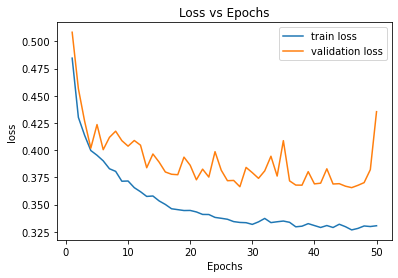

In [13]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs, device)
plot_performance(loss_train, loss_valid)

#### Performance of the Model with Data Augmentation

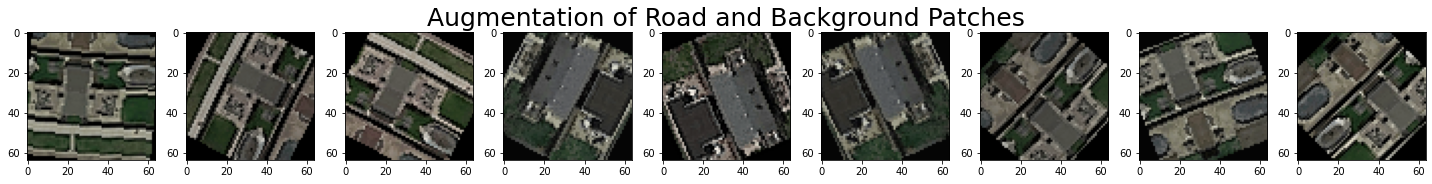

In [14]:
# Visualize possible augmentations for road and background patches from the Training dataset
ind_patches = [10, 5, 9]
fig, ax = plt.subplots(1, 3*len(ind_patches), figsize=(20, 20))
for i in range (3):
    for j in range (len(ind_patches)):
        ax[i + 3*j].imshow(augmentation(img_patches[ind_patches[j]]).permute(1, 2, 0).numpy())

ax[4].set_title("Augmentation of Road and Background Patches", fontdict={'fontsize':25})
plt.tight_layout()

In [16]:
# Augmented Training dataset and validation set
img_train, img_valid, Y_train, Y_valid = train_test_split(img_patches, Y, test_size=0.2)

batch_size = 200
sampler = balanced_sampler(Y_train)
trainsetAugmented = TrainsetCNN(img_train, Y_train, mean_img, std_img, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

validset = TrainsetCNN(img_valid, Y_valid, mean_img, std_img)
dataset_valid = DataLoader(validset, batch_size=batch_size, shuffle=True)

Dealing with imbalanced datasets
Background weight: 0.676
Road weight: 1.923


Starting training


100%|████████████████████████████████████████| 250/250 [01:28<00:00,  2.82it/s]


Epoch 1
val accuracy: 0.72079, f1-score: 0.55841



100%|████████████████████████████████████████| 250/250 [01:26<00:00,  2.89it/s]


Epoch 2
val accuracy: 0.77024, f1-score: 0.64776



100%|████████████████████████████████████████| 250/250 [01:26<00:00,  2.90it/s]


Epoch 3
val accuracy: 0.72913, f1-score: 0.51706



100%|████████████████████████████████████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 4
val accuracy: 0.75000, f1-score: 0.64856



100%|████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 5
val accuracy: 0.74294, f1-score: 0.54104



100%|████████████████████████████████████████| 250/250 [01:28<00:00,  2.84it/s]


Epoch 6
val accuracy: 0.75944, f1-score: 0.65663



100%|████████████████████████████████████████| 250/250 [01:27<00:00,  2.87it/s]


Epoch 7
val accuracy: 0.81540, f1-score: 0.70038



100%|████████████████████████████████████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 8
val accuracy: 0.77730, f1-score: 0.66131



100%|████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 9
val accuracy: 0.80698, f1-score: 0.69699



100%|████████████████████████████████████████| 250/250 [01:20<00:00,  3.10it/s]


Epoch 10
val accuracy: 0.78246, f1-score: 0.65195



100%|████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 11
val accuracy: 0.75349, f1-score: 0.66100



100%|████████████████████████████████████████| 250/250 [01:22<00:00,  3.03it/s]


Epoch 12
val accuracy: 0.83000, f1-score: 0.72154



100%|████████████████████████████████████████| 250/250 [01:19<00:00,  3.16it/s]


Epoch 13
val accuracy: 0.75468, f1-score: 0.66081



100%|████████████████████████████████████████| 250/250 [01:23<00:00,  3.01it/s]


Epoch 14
val accuracy: 0.83563, f1-score: 0.72436



100%|████████████████████████████████████████| 250/250 [01:23<00:00,  2.99it/s]


Epoch 15
val accuracy: 0.86532, f1-score: 0.73304



100%|████████████████████████████████████████| 250/250 [01:22<00:00,  3.02it/s]


Epoch 16
val accuracy: 0.86071, f1-score: 0.76698



100%|████████████████████████████████████████| 250/250 [01:25<00:00,  2.92it/s]


Epoch 17
val accuracy: 0.88508, f1-score: 0.77996



100%|████████████████████████████████████████| 250/250 [01:26<00:00,  2.88it/s]


Epoch 18
val accuracy: 0.71071, f1-score: 0.61446



100%|████████████████████████████████████████| 250/250 [01:22<00:00,  3.02it/s]


Epoch 19
val accuracy: 0.84286, f1-score: 0.74987



100%|████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 20
val accuracy: 0.83635, f1-score: 0.67070



100%|████████████████████████████████████████| 250/250 [01:20<00:00,  3.09it/s]


Epoch 21
val accuracy: 0.87333, f1-score: 0.78585



100%|████████████████████████████████████████| 250/250 [01:14<00:00,  3.37it/s]


Epoch 22
val accuracy: 0.86881, f1-score: 0.76392



100%|████████████████████████████████████████| 250/250 [01:14<00:00,  3.38it/s]


Epoch 23
val accuracy: 0.87254, f1-score: 0.78205



100%|████████████████████████████████████████| 250/250 [01:14<00:00,  3.34it/s]


Epoch 24
val accuracy: 0.89040, f1-score: 0.80176



100%|████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 25
val accuracy: 0.86230, f1-score: 0.76418



100%|████████████████████████████████████████| 250/250 [01:16<00:00,  3.29it/s]


Epoch 26
val accuracy: 0.86008, f1-score: 0.77283



100%|████████████████████████████████████████| 250/250 [01:13<00:00,  3.39it/s]


Epoch 27
val accuracy: 0.84365, f1-score: 0.74650



100%|████████████████████████████████████████| 250/250 [01:14<00:00,  3.37it/s]


Epoch 28
val accuracy: 0.88071, f1-score: 0.79770



100%|████████████████████████████████████████| 250/250 [01:17<00:00,  3.23it/s]


Epoch 29
val accuracy: 0.88317, f1-score: 0.79968



100%|████████████████████████████████████████| 250/250 [01:13<00:00,  3.41it/s]


Epoch 30
val accuracy: 0.84603, f1-score: 0.75905



100%|████████████████████████████████████████| 250/250 [01:13<00:00,  3.41it/s]


Epoch 31
val accuracy: 0.86246, f1-score: 0.76689



100%|████████████████████████████████████████| 250/250 [01:19<00:00,  3.14it/s]


Epoch 32
val accuracy: 0.87817, f1-score: 0.79477



100%|████████████████████████████████████████| 250/250 [01:18<00:00,  3.18it/s]


Epoch 33
val accuracy: 0.89992, f1-score: 0.81778



100%|████████████████████████████████████████| 250/250 [01:14<00:00,  3.34it/s]


Epoch 34
val accuracy: 0.90524, f1-score: 0.82833



100%|████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 35
val accuracy: 0.87952, f1-score: 0.79086



100%|████████████████████████████████████████| 250/250 [01:17<00:00,  3.22it/s]


Epoch 36
val accuracy: 0.89349, f1-score: 0.81096



100%|████████████████████████████████████████| 250/250 [01:15<00:00,  3.32it/s]


Epoch 37
val accuracy: 0.87389, f1-score: 0.78608



100%|████████████████████████████████████████| 250/250 [01:19<00:00,  3.13it/s]


Epoch 38
val accuracy: 0.89921, f1-score: 0.81023



100%|████████████████████████████████████████| 250/250 [01:21<00:00,  3.06it/s]


Epoch 39
val accuracy: 0.85944, f1-score: 0.73320



100%|████████████████████████████████████████| 250/250 [01:24<00:00,  2.97it/s]


Epoch 40
val accuracy: 0.89317, f1-score: 0.81102



100%|████████████████████████████████████████| 250/250 [01:23<00:00,  3.00it/s]


Epoch 41
val accuracy: 0.81738, f1-score: 0.72490



100%|████████████████████████████████████████| 250/250 [01:17<00:00,  3.21it/s]


Epoch 42
val accuracy: 0.89881, f1-score: 0.81724



100%|████████████████████████████████████████| 250/250 [01:17<00:00,  3.23it/s]


Epoch 43
val accuracy: 0.88357, f1-score: 0.80031



100%|████████████████████████████████████████| 250/250 [01:15<00:00,  3.31it/s]


Epoch 44
val accuracy: 0.88190, f1-score: 0.79877



100%|████████████████████████████████████████| 250/250 [01:15<00:00,  3.29it/s]


Epoch 45
val accuracy: 0.89214, f1-score: 0.79152



100%|████████████████████████████████████████| 250/250 [01:20<00:00,  3.12it/s]


Epoch 46
val accuracy: 0.90040, f1-score: 0.82568



100%|████████████████████████████████████████| 250/250 [01:19<00:00,  3.15it/s]


Epoch 47
val accuracy: 0.90333, f1-score: 0.82828



100%|████████████████████████████████████████| 250/250 [01:16<00:00,  3.28it/s]


Epoch 48
val accuracy: 0.90571, f1-score: 0.83200



100%|████████████████████████████████████████| 250/250 [01:20<00:00,  3.11it/s]


Epoch 49
val accuracy: 0.90540, f1-score: 0.83272



100%|████████████████████████████████████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 50
val accuracy: 0.90841, f1-score: 0.83614

Finished


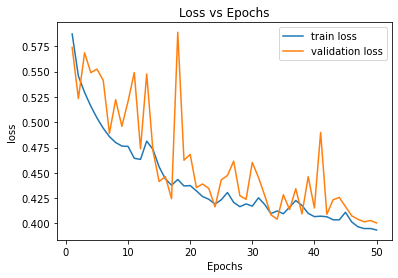

In [17]:
# Training the CNN on the Augmented Dataset
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode="max")
loss_train, loss_valid = train(model_lenet, criterion, dataset_train, dataset_valid, optimizer, scheduler, num_epochs, device)
plot_performance(loss_train, loss_valid)

#### Prediction of the CNN for one test image

Text(0.5, 1.0, 'Test Image 1')

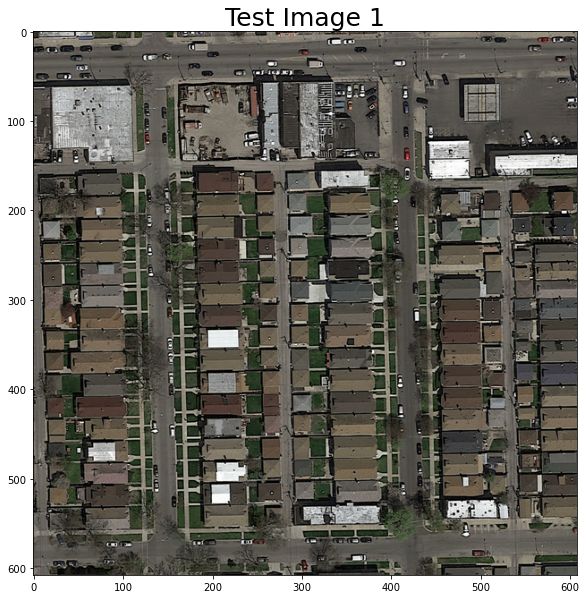

In [18]:
# Load all test images
test_images = list(glob.iglob(image_test + '/*/*.png', recursive=True))

# Extract one test image for visualization
test_1_path = test_images[0]
test_1 = load_image(test_1_path)

# show test image 1
plt.figure(figsize=(10, 10))
plt.imshow(test_1)
plt.title("Test Image 1", fontdict={'fontsize':25})

100%|████████████████████████████████████████████| 8/8 [00:03<00:00,  2.30it/s]


True positive rate = 0.139196675900277


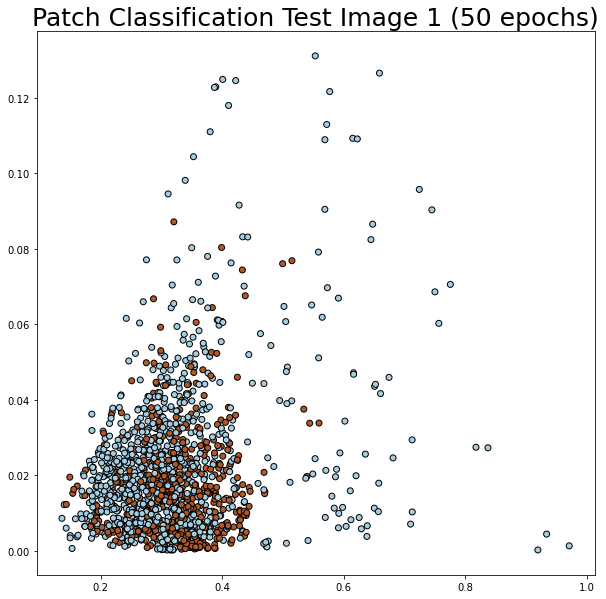

In [30]:
# Test set of image patches
patches_test = np.array(img_crop(test_1, patch_size, padding))
dataset_test = torch.utils.data.DataLoader(TestsetCNN(patches_test, mean_img, std_img), batch_size=batch_size, shuffle=False)

# Running the prediction for the test image
Zi = predict(model_lenet.cpu(), dataset_test)

# Get non-zeros in prediction and grountruth arrays
Zn = np.nonzero(Zi)[0]
Yn = np.nonzero(Y)[0]
TPR = len(list(set(Yn) & set(Zn))) / float(len(Zi))
print('True positive rate = ' + str(TPR))

# Plot features using predictions to color datapoints
patches_test_2D = extract_img_features(test_1_path, patch_size)
plt.figure(figsize=(10, 10))
plt.scatter(patches_test_2D[:, 0], patches_test_2D[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.title("Patch Classification Test Image 1 ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.show()

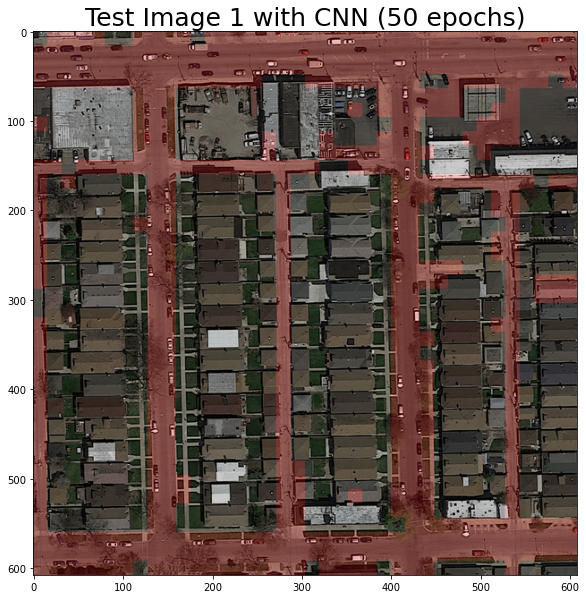

In [31]:
# Display prediction as an image

w = test_1.shape[0]
h = test_1.shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(test_1, predicted_im)
plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(test_1, predicted_im)

plt.title("Test Image 1 with CNN ({} epochs)".format(num_epochs), fontdict={'fontsize':25})
plt.imshow(new_img)

## Generating the predictions for the submission

In [33]:
# hyperparameters
num_epochs = 50
learning_rate = 1e-3

# Criterion to optimize
criterion = torch.nn.CrossEntropyLoss()

In [34]:
# Building the augmented training set
batch_size = 200
sampler = balanced_sampler(Y)
trainsetAugmented = TrainsetCNN(img_patches, Y, mean_img, std_img, augmentation)
dataset_train = DataLoader(trainsetAugmented, batch_size=batch_size, sampler=sampler)

Dealing with imbalanced datasets
Background weight: 0.675
Road weight: 1.930


In [35]:
# Training the CNN
model_lenet = LeNetModel().to(device)
optimizer = torch.optim.Adam(model_lenet.parameters(), lr=learning_rate)
train_submissions(model_lenet, criterion, dataset_train, optimizer, num_epochs, device)

Starting training


100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 1
train f1-score: 0.77705



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 2
train f1-score: 0.82145



100%|████████████████████████████████████████| 313/313 [01:50<00:00,  2.84it/s]


Epoch 3
train f1-score: 0.83154



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 4
train f1-score: 0.84183



100%|████████████████████████████████████████| 313/313 [02:05<00:00,  2.48it/s]


Epoch 5
train f1-score: 0.85488



100%|████████████████████████████████████████| 313/313 [01:57<00:00,  2.67it/s]


Epoch 6
train f1-score: 0.85619



100%|████████████████████████████████████████| 313/313 [02:02<00:00,  2.55it/s]


Epoch 7
train f1-score: 0.86352



100%|████████████████████████████████████████| 313/313 [02:02<00:00,  2.56it/s]


Epoch 8
train f1-score: 0.86654



100%|████████████████████████████████████████| 313/313 [02:00<00:00,  2.59it/s]


Epoch 9
train f1-score: 0.87135



100%|████████████████████████████████████████| 313/313 [01:58<00:00,  2.63it/s]


Epoch 10
train f1-score: 0.87169



100%|████████████████████████████████████████| 313/313 [01:51<00:00,  2.80it/s]


Epoch 11
train f1-score: 0.87697



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.76it/s]


Epoch 12
train f1-score: 0.87602



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.75it/s]


Epoch 13
train f1-score: 0.88255



100%|████████████████████████████████████████| 313/313 [02:01<00:00,  2.58it/s]


Epoch 14
train f1-score: 0.88673



100%|████████████████████████████████████████| 313/313 [02:05<00:00,  2.50it/s]


Epoch 15
train f1-score: 0.88355



100%|████████████████████████████████████████| 313/313 [02:04<00:00,  2.52it/s]


Epoch 16
train f1-score: 0.88311



100%|████████████████████████████████████████| 313/313 [02:00<00:00,  2.60it/s]


Epoch 17
train f1-score: 0.88866



100%|████████████████████████████████████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch 18
train f1-score: 0.88906



100%|████████████████████████████████████████| 313/313 [01:57<00:00,  2.67it/s]


Epoch 19
train f1-score: 0.88866



100%|████████████████████████████████████████| 313/313 [01:58<00:00,  2.63it/s]


Epoch 20
train f1-score: 0.88945



100%|████████████████████████████████████████| 313/313 [01:59<00:00,  2.63it/s]


Epoch 21
train f1-score: 0.89088



100%|████████████████████████████████████████| 313/313 [02:01<00:00,  2.57it/s]


Epoch 22
train f1-score: 0.88961



100%|████████████████████████████████████████| 313/313 [01:59<00:00,  2.62it/s]


Epoch 23
train f1-score: 0.89165



100%|████████████████████████████████████████| 313/313 [01:56<00:00,  2.70it/s]


Epoch 24
train f1-score: 0.89325



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.78it/s]


Epoch 25
train f1-score: 0.89276



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.79it/s]


Epoch 26
train f1-score: 0.89357



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.79it/s]


Epoch 27
train f1-score: 0.89248



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.78it/s]


Epoch 28
train f1-score: 0.89885



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.77it/s]


Epoch 29
train f1-score: 0.89583



100%|████████████████████████████████████████| 313/313 [01:56<00:00,  2.70it/s]


Epoch 30
train f1-score: 0.89734



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.77it/s]


Epoch 31
train f1-score: 0.89720



100%|████████████████████████████████████████| 313/313 [01:52<00:00,  2.77it/s]


Epoch 32
train f1-score: 0.89970



100%|████████████████████████████████████████| 313/313 [01:55<00:00,  2.72it/s]


Epoch 33
train f1-score: 0.89629



100%|████████████████████████████████████████| 313/313 [01:55<00:00,  2.72it/s]


Epoch 34
train f1-score: 0.90107



100%|████████████████████████████████████████| 313/313 [01:54<00:00,  2.74it/s]


Epoch 35
train f1-score: 0.89652



100%|████████████████████████████████████████| 313/313 [01:56<00:00,  2.69it/s]


Epoch 36
train f1-score: 0.90078



100%|████████████████████████████████████████| 313/313 [01:50<00:00,  2.83it/s]


Epoch 37
train f1-score: 0.90240



100%|████████████████████████████████████████| 313/313 [01:47<00:00,  2.91it/s]


Epoch 38
train f1-score: 0.90034



100%|████████████████████████████████████████| 313/313 [01:51<00:00,  2.80it/s]


Epoch 39
train f1-score: 0.90313



100%|████████████████████████████████████████| 313/313 [01:54<00:00,  2.73it/s]


Epoch 40
train f1-score: 0.90194



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.75it/s]


Epoch 41
train f1-score: 0.90406



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.75it/s]


Epoch 42
train f1-score: 0.90286



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.77it/s]


Epoch 43
train f1-score: 0.90354



100%|████████████████████████████████████████| 313/313 [01:55<00:00,  2.70it/s]


Epoch 44
train f1-score: 0.90465



100%|████████████████████████████████████████| 313/313 [01:50<00:00,  2.82it/s]


Epoch 45
train f1-score: 0.90529



100%|████████████████████████████████████████| 313/313 [01:55<00:00,  2.71it/s]


Epoch 46
train f1-score: 0.90139



100%|████████████████████████████████████████| 313/313 [01:53<00:00,  2.77it/s]


Epoch 47
train f1-score: 0.90488



100%|████████████████████████████████████████| 313/313 [01:55<00:00,  2.71it/s]


Epoch 48
train f1-score: 0.90618



100%|████████████████████████████████████████| 313/313 [01:48<00:00,  2.89it/s]


Epoch 49
train f1-score: 0.90644



100%|████████████████████████████████████████| 313/313 [01:57<00:00,  2.65it/s]

Epoch 50
train f1-score: 0.90561

Finished


In [36]:
test_files = list(glob.iglob(image_test + '/*/*.png', recursive=True))
masks_to_submission(model_lenet.cpu(), "submission.csv", test_files, patch_size, padding, mean_img, std_img)

100%|██████████████████████████████████████████| 50/50 [05:40<00:00,  6.81s/it]
